In [1]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from model import PyTorchModel, PyTorchModel_defended

In [2]:
import datetime
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import sklearn

In [3]:
batchSize = 10

In [4]:
# In this notebook we will perform Adversarial Patch attack on the model, by treating a training sample as a 2D image (90 X 3) and placing a patch on it.
# We will use the PyTorch framework to implement the attack.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

True

In [6]:
model_defended = PyTorchModel_defended()
model_defended.load_state_dict(torch.load('model_pytorch_defended_balanced_30ep_2.pth'))

model_undefended = PyTorchModel()
model_undefended.load_state_dict(torch.load('model_pytorch_balanced.pth'))

<All keys matched successfully>

In [7]:
model_defended = model_defended.to(device)
model_undefended = model_undefended.to(device)

In [8]:
testX = np.load('testData.npy')
testY = np.load('groundTruth.npy')
trainX = np.load('trainData_balanced.npy')
trainY = np.load('trainLabels_balanced.npy')

# Convert the training and testing data to PyTorch tensors
trainX_torch = torch.from_numpy(np.transpose(trainX, (0, 3, 1, 2))).float()
trainY_torch = torch.from_numpy(np.argmax(trainY, axis=1)).long()
testX_torch = torch.from_numpy(np.transpose(testX, (0, 3, 1, 2))).float()
testY_torch = torch.from_numpy(np.argmax(testY, axis=1)).long()

# Create TensorDatasets for training and testing data
train_data = TensorDataset(trainX_torch, trainY_torch)
test_data = TensorDataset(testX_torch, testY_torch)

# Create DataLoaders for training and testing data
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)

In [9]:
"""
this was to oversample the training data for the HAR.py - 
and this is then also used here for training to create patches
but it is not needed now since the data is generated
"""

# # make one hot input ordinal
# trainY_ordinal = np.argmax(trainY, axis=1)

# # reshape signals to be 2dimensional, because this is required for oversampling
# trainX_flat = trainX.reshape(trainX.shape[0], -1)

# oversample = RandomOverSampler(sampling_strategy='auto')
# trainX_flat_bal, trainY_bal = oversample.fit_resample(trainX_flat, trainY_ordinal)

# # convert signal back to original shape
# trainX_bal = trainX_flat_bal.reshape(trainX_flat_bal.shape[0], 90, 3, 1)

# # make classes one hot encoded again
# trainY_bal = np.eye(6)[trainY_bal]

# np.save('trainData_balanced.npy', trainX_bal)
# np.save('trainLabels_balanced.npy', trainY_bal)

'\nthis was to oversample the training data for the HAR.py - \nand this is then also used here for training to create patches\nbut it is not needed now since the data is generated\n'

In [10]:
# Now we will try to attack the network using Adversarial Patch
# We will treat each sample as a 2D image and place a patch on it

# This function is used to normalize the data
def patch_forward(patch):
    #patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    #TODO: is this right way to do this? If not normalised do the line above?
    patch = torch.tanh(patch)
    return patch

In [11]:
def plot_sample(sample):
    sample = np.transpose(sample.detach().numpy())
    plt.imshow(sample, aspect='auto')
    plt.show()

In [12]:
# Place patch in each sample
def place_patch(data, patch_train):
    #data shape:           torch.Size([10, 1, 90, 3])
    #patch shape example:  torch.Size([20, 3])
    
    if patch_train.shape[1] > 3 or patch_train.shape[0] > data.shape[2]:
        print('Patch shape exceeds data shape and is invalid!')
        return

    for i in range(data.shape[0]): #for each sample
        if data.shape[2] != patch_train.shape[0]:
            w = np.random.randint(0, data.shape[2] - patch_train.shape[0]) #randomly select a starting point for the patch
        else:
            w = 0
            
        if data.shape[3] != patch_train.shape[1]:
            h = np.random.randint(0, data.shape[3] - patch_train.shape[1]) #randomly select a starting point for the patch
        else:
            h = 0
            
        data[i, :, w:w + patch_train.shape[0], h:h + patch_train.shape[1]] = patch_forward(patch_train)#.reshape(patch_train.shape[0], patch_train.shape[1], 1)
    return data

In [13]:
# Define the eval_patch function
def eval_patch(model, p, test_loader, target_class):
    model.eval()
    tp, counter = 0., 0.
    with torch.no_grad():
        for sample, labels in tqdm(test_loader, desc="Evaluating patch...", leave=False):
            for _ in range(2): # place patch at 2 random locations and average
                patched_sample = place_patch(sample, p)
                patched_sample = patched_sample.to(device)
                labels = labels.to(device)
                predictions = model(patched_sample)
                tp += torch.logical_and(predictions.argmax(dim=-1) == target_class, labels != target_class).sum()
                counter += (labels != target_class).sum()
    acc = tp / counter
    return acc

In [14]:
# Define the patch_attack function # TORCH
def patch_attack(model, train_loader, test_loader, target_class, patch_size=(20,3), num_epochs=5):
    assert isinstance(patch_size, tuple) and len(patch_size) == 2
    patch = nn.Parameter(torch.zeros(patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8) #adam?
    loss_module = nn.CrossEntropyLoss()

    accs = []
    for epoch in range(num_epochs):
        for batch, t_labels in train_loader:               
            batch = place_patch(batch, patch)
            batch = batch.to(device).float()
            predictions = model(batch)
            labels = torch.zeros(batch.shape[0], device=predictions.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(predictions, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item():4.2f}", end= "\t")
        
        
    return patch.data, accs

In [15]:
patch_dir = "patches_3"

def make_patches(model, trainloader, test_loader, patch_size, num_epochs, patches_target_class):
    start_time = datetime.datetime.now()
    patch_size_str = f"size_{patch_size[0]}_{patch_size[1]}"
    for target_class in patches_target_class.keys():
        for patch_num in range(patches_target_class[target_class]):
            print(f"TARGET CLASS: {target_class} patch number {patch_num}")
            patch_data, acc = patch_attack(model, train_loader, test_loader, target_class, patch_size, num_epochs)
            patch_file_name = f"class_{target_class}_patch_{patch_num}_{patch_size_str}_ep_{num_epochs}.pt"
            # print(patch_file_name)
            torch.save(patch_data, os.path.join(patch_dir, patch_file_name))
            
            cur_time = datetime.datetime.now()
            print(patch_file_name, cur_time)
            print(f"elapsed: {cur_time - start_time}")


In [20]:
"""variations:

patch size - 10x3, 20x3, 
            10x1, 20x1, 10x2, 20x2, 
            1x90, 2x90, 3x90, 
            3x45, 2x45, 1x45
epochs trained: 5, 15, 40 (with early stopping?)
batch size: 10, 20, 60
"""

'variations:\n\npatch size - 10x3, 20x3, \n            10x1, 20x1, 10x2, 20x2, \n            1x90, 2x90, 3x90, \n            3x45, 2x45, 1x45\nepochs trained: 5, 15, 40 (with early stopping?)\nbatch size: 10, 20, 60\n'

In [ ]:
target_patch_class = {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5}
make_patches(model_undefended, train_loader, test_loader, patch_size = (10,3), num_epochs=10, patches_target_class=target_patch_class)

TARGET CLASS: 0 patch number 0


  0%|          | 0/4520 [00:00<?, ?it/s]/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning5/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 9, Loss: 77.23:  10%|█         | 461/4520 [00:01<00:15, 258.91it/s]  

In [ ]:
target_patch_class = {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5}
make_patches(model_undefended, train_loader, test_loader, patch_size = (20,3), num_epochs=10, patches_target_class=target_patch_class)

In [ ]:
target_patch_class = {0:5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5}
make_patches(model_undefended, train_loader, test_loader, patch_size = (30,3), num_epochs=10, patches_target_class=target_patch_class)

In [16]:
patch_list = os.listdir("patches_3")

In [23]:
patches_10_3 = list(filter(lambda x: "size_10_3" in x, patch_list))
patches_10_3

['class_0_patch_0_size_10_3_ep_10.pt',
 'class_0_patch_1_size_10_3_ep_10.pt',
 'class_0_patch_2_size_10_3_ep_10.pt',
 'class_0_patch_3_size_10_3_ep_10.pt',
 'class_0_patch_4_size_10_3_ep_10.pt',
 'class_2_patch_1_size_10_3_ep_10.pt',
 'class_2_patch_2_size_10_3_ep_10.pt',
 'class_2_patch_3_size_10_3_ep_10.pt',
 'class_2_patch_4_size_10_3_ep_10.pt',
 'class_3_patch_0_size_10_3_ep_10.pt',
 'class_3_patch_1_size_10_3_ep_10.pt',
 'class_3_patch_3_size_10_3_ep_10.pt',
 'class_3_patch_4_size_10_3_ep_10.pt',
 'class_4_patch_0_size_10_3_ep_10.pt',
 'class_4_patch_1_size_10_3_ep_10.pt',
 'class_4_patch_2_size_10_3_ep_10.pt',
 'class_4_patch_3_size_10_3_ep_10.pt',
 'class_1_patch_0_size_10_3_ep_10.pt',
 'class_1_patch_1_size_10_3_ep_10.pt',
 'class_1_patch_2_size_10_3_ep_10.pt',
 'class_1_patch_3_size_10_3_ep_10.pt',
 'class_1_patch_4_size_10_3_ep_10.pt',
 'class_2_patch_0_size_10_3_ep_10.pt',
 'class_3_patch_2_size_10_3_ep_10.pt',
 'class_4_patch_4_size_10_3_ep_10.pt',
 'class_5_patch_0_size_10

In [27]:
len(patch_list)

90

In [29]:
class_acc_def = {}
class_acc_undef = {}

results = []
for patch_item in patch_list:

    rec = {}
    
    patch_class = int(patch_item[6])
    rec['patch_name'] = patch_item
    rec['patch_class'] = patch_class
    rec['patch_size'] = patch_item[21:25]
    
    patch = torch.load(os.path.join("patches_3", patch_item))
    
    acc_undef = eval_patch(model_undefended, patch, test_loader, target_class=patch_class)
    acc_def = eval_patch(model_defended, patch, test_loader, target_class=patch_class)
    rec['acc_undef'] = round(float(acc_undef.cpu().numpy()),3)
    rec['acc_def'] = round(float(acc_def.cpu().numpy()),3)
    results.append(rec)

In [30]:
results

[{'patch_name': 'class_0_patch_0_size_10_3_ep_10.pt',
  'patch_class': 0,
  'patch_size': '10_3',
  'acc_undef': 0.218,
  'acc_def': 0.206},
 {'patch_name': 'class_0_patch_0_size_20_3_ep_10.pt',
  'patch_class': 0,
  'patch_size': '20_3',
  'acc_undef': 0.067,
  'acc_def': 0.086},
 {'patch_name': 'class_0_patch_0_size_30_3_ep_10.pt',
  'patch_class': 0,
  'patch_size': '30_3',
  'acc_undef': 0.689,
  'acc_def': 0.352},
 {'patch_name': 'class_0_patch_1_size_10_3_ep_10.pt',
  'patch_class': 0,
  'patch_size': '10_3',
  'acc_undef': 0.225,
  'acc_def': 0.195},
 {'patch_name': 'class_0_patch_1_size_20_3_ep_10.pt',
  'patch_class': 0,
  'patch_size': '20_3',
  'acc_undef': 0.061,
  'acc_def': 0.084},
 {'patch_name': 'class_0_patch_1_size_30_3_ep_10.pt',
  'patch_class': 0,
  'patch_size': '30_3',
  'acc_undef': 0.698,
  'acc_def': 0.326},
 {'patch_name': 'class_0_patch_2_size_10_3_ep_10.pt',
  'patch_class': 0,
  'patch_size': '10_3',
  'acc_undef': 0.195,
  'acc_def': 0.206},
 {'patch_name

Text(0.5, 1.0, 'Patch size: 30x3')

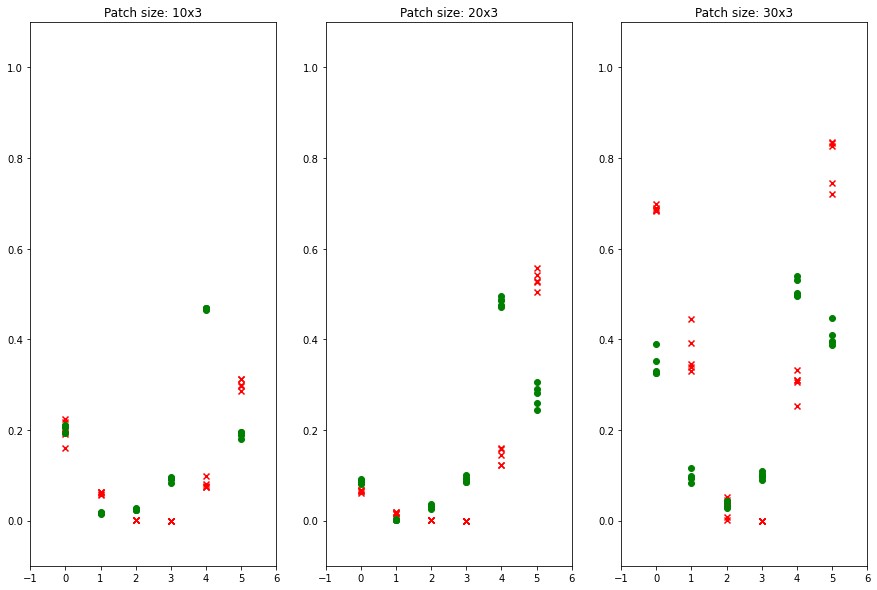

In [43]:
fig, axs = plt.subplots(1,3, figsize=(15,10))

scatter1 = {'0':[], '0def':[],'1':[], '1def':[],'2':[], '2def':[],'3':[], '3def':[],'4':[], '4def':[],'5':[], '5def':[]}
scatter2 = {'0':[], '0def':[],'1':[], '1def':[],'2':[], '2def':[],'3':[], '3def':[],'4':[], '4def':[],'5':[], '5def':[]}
scatter3 = {'0':[], '0def':[],'1':[], '1def':[],'2':[], '2def':[],'3':[], '3def':[],'4':[], '4def':[],'5':[], '5def':[]}

for rec in results:
    if rec['patch_size'] == "10_3":
        subplot_i = 0
    if rec['patch_size'] == "20_3":
        subplot_i = 1
    if rec['patch_size'] == "30_3":
        subplot_i = 2
    
    axs[subplot_i].scatter(rec['patch_class'], rec['acc_undef'], marker='x', c = ['red'], label='undefended')
    axs[subplot_i].scatter(rec['patch_class'], rec['acc_def'], marker='o', c = ['green'], label='defended')
for i in range(3):
    axs[i].set_xlim(-1,6)
    axs[i].set_ylim(-0.1,1.1)

axs[0].set_title("Patch size: 10x3")
axs[1].set_title("Patch size: 20x3")
axs[2].set_title("Patch size: 30x3")

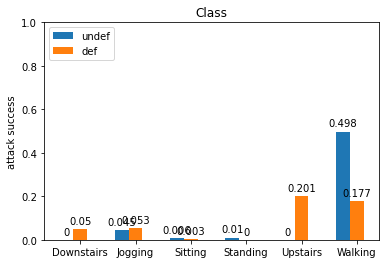

In [33]:
classes = labels = ('Downstairs','Jogging','Sitting','Standing','Upstairs','Walking')
species = ("Adelie", "Chinstrap", "Gentoo")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}
class_acc = {
    'undef': list(class_acc_undef.values()),
    'def': list(class_acc_def.values())
}

x = np.arange(6)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in class_acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('attack success')
ax.set_title('Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend(loc='upper left')
ax.set_ylim(0, 1)

plt.show()

In [23]:
for patch_item in patch_list[1::2]:
    patch = torch.load(os.path.join("patches_2", patch_item))
    patch_class = int(patch_item[6])
    print(patch_item, end="\t")
    acc_undef = eval_patch(model_undefended, patch, test_loader, target_class=patch_class)
    acc_def = eval_patch(model_defended, patch, test_loader, target_class=patch_class)
    print("%.4f %.4f" %(acc_undef.cpu().numpy(), acc_def.cpu().numpy()) )

class_0_patch_0_size_10_3_ep_10.pt	

0.0009 0.0463
class_1_patch_0_size_10_3_ep_10.pt	

0.0415 0.0454
class_2_patch_0_size_10_3_ep_10.pt	

0.0062 0.0042
class_3_patch_0_size_10_3_ep_10.pt	

0.0104 0.0000
class_4_patch_0_size_10_3_ep_10.pt	

0.0000 0.2410
class_5_patch_0_size_10_3_ep_10.pt	

0.4962 0.1450


Epoch 0, FOOLING Test Accuracy: 0.67


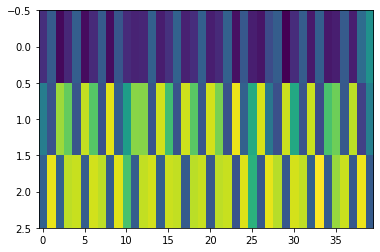

Epoch 1, FOOLING Test Accuracy: 0.66


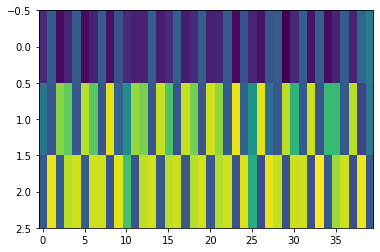

Epoch 2, FOOLING Test Accuracy: 0.68


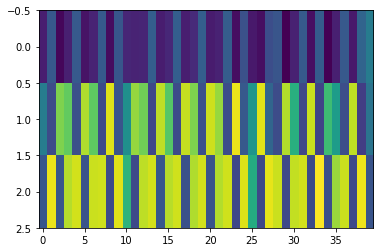

Epoch 3, FOOLING Test Accuracy: 0.67


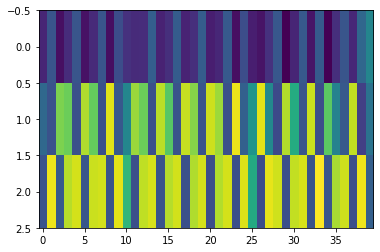

Epoch 4, FOOLING Test Accuracy: 0.68


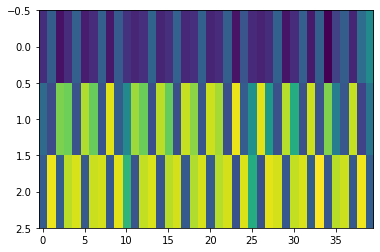

Epoch 5, FOOLING Test Accuracy: 0.67


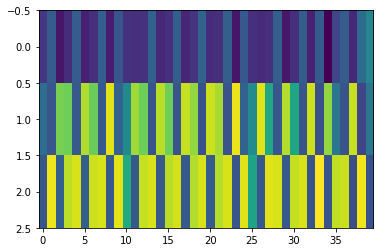

Epoch 6, FOOLING Test Accuracy: 0.69


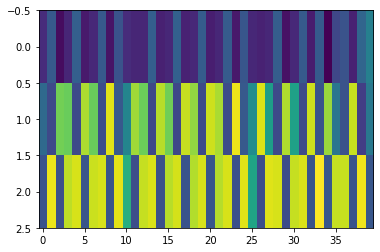

Epoch 7, FOOLING Test Accuracy: 0.67


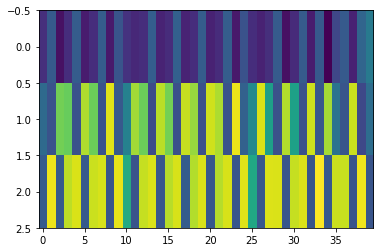

Epoch 8, FOOLING Test Accuracy: 0.67


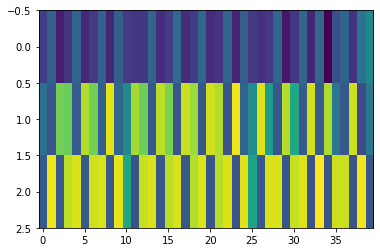

Epoch 9, FOOLING Test Accuracy: 0.69


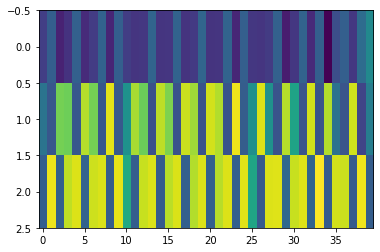

Epoch 0, FOOLING Test Accuracy: 0.01


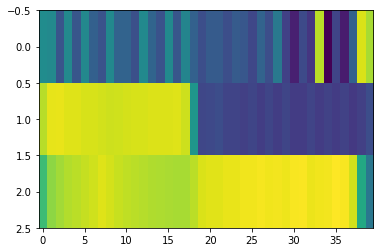

Epoch 1, FOOLING Test Accuracy: 0.01


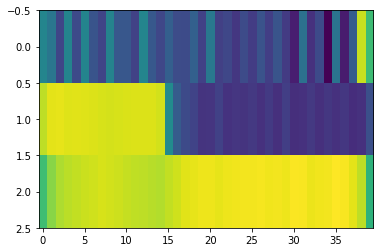

Epoch 2, FOOLING Test Accuracy: 0.01


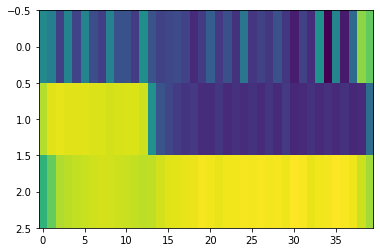

Epoch 3, FOOLING Test Accuracy: 0.01


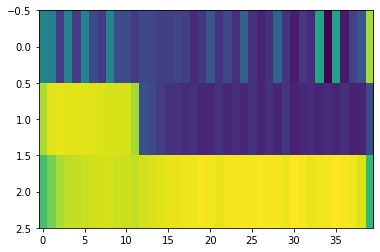

Epoch 4, FOOLING Test Accuracy: 0.01


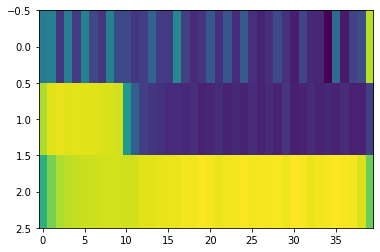

Epoch 5, FOOLING Test Accuracy: 0.02


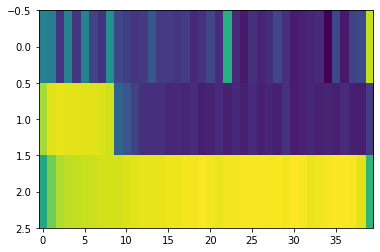

Epoch 6, FOOLING Test Accuracy: 0.02


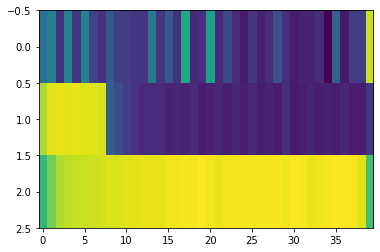

Epoch 7, FOOLING Test Accuracy: 0.02


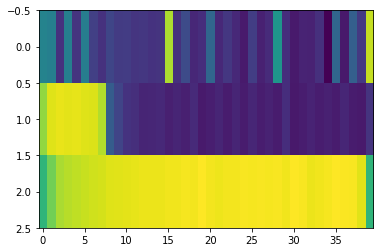

Epoch 8, FOOLING Test Accuracy: 0.02


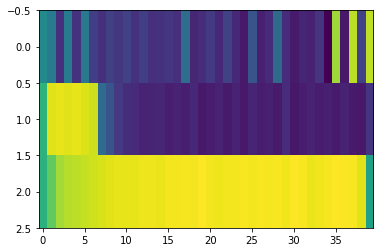

Epoch 9, FOOLING Test Accuracy: 0.02


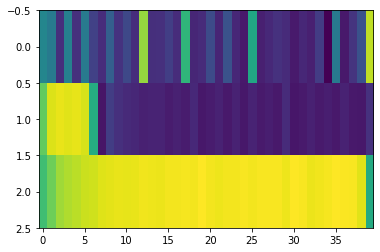

Fooling accuracy defended vs. undefended: 0.6731552481651306 vs. 0.011543684639036655


In [17]:
# Run the patch_attack function
patch_def, metrics_def = patch_attack(model_defended, train_loader, test_loader, target_class=0, patch_size=(40,3), num_epochs=10)
patch, metrics = patch_attack(model_undefended, train_loader, test_loader, target_class=0, patch_size=(40,3), num_epochs=10)
print(f'Fooling accuracy defended vs. undefended: {metrics_def[0]} vs. {metrics[0]}')

In [19]:
metrics_def

[0.5222094655036926,
 0.5264672040939331,
 0.5249712467193604,
 0.5235903263092041,
 0.5284234881401062,
 0.5369390249252319,
 0.5134637355804443,
 0.5148446559906006,
 0.526121973991394,
 0.5191023945808411]

Epoch 0, FOOLING Test Accuracy: 0.52


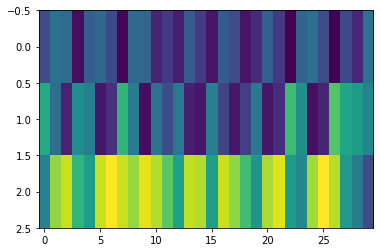

Epoch 1, FOOLING Test Accuracy: 0.53


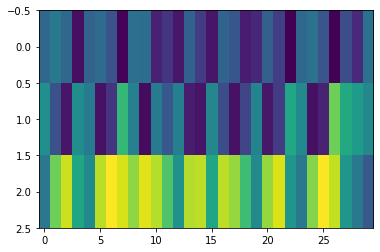

Epoch 2, FOOLING Test Accuracy: 0.52


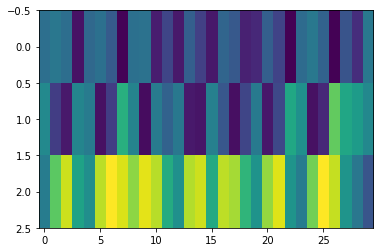

Epoch 3, FOOLING Test Accuracy: 0.52


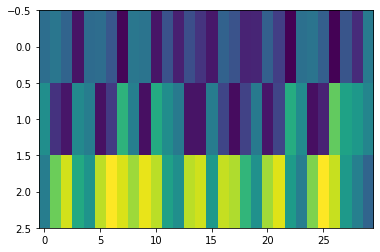

Epoch 4, FOOLING Test Accuracy: 0.53


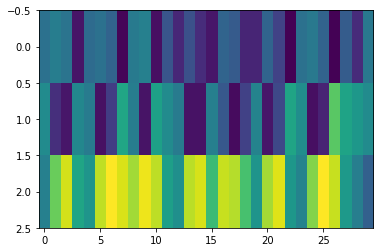

Epoch 5, FOOLING Test Accuracy: 0.54


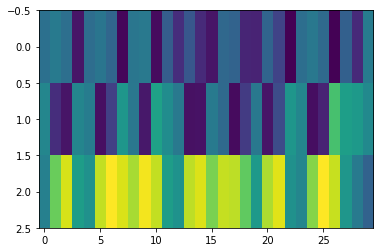

Epoch 6, FOOLING Test Accuracy: 0.51


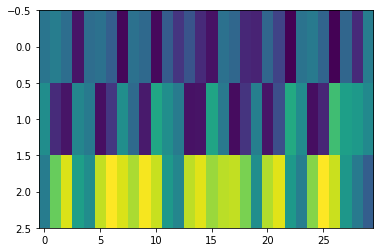

Epoch 7, FOOLING Test Accuracy: 0.51


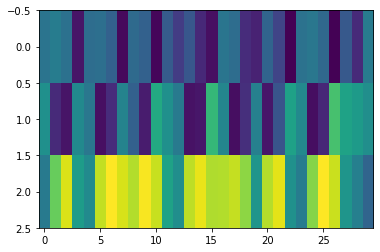

Epoch 8, FOOLING Test Accuracy: 0.53


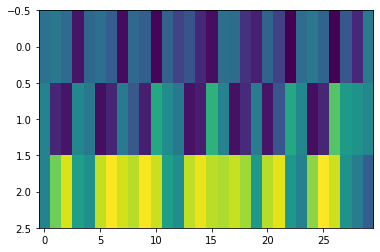

Epoch 9, FOOLING Test Accuracy: 0.52


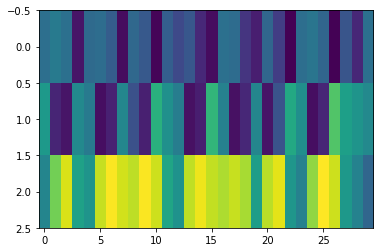

Epoch 0, FOOLING Test Accuracy: 0.00


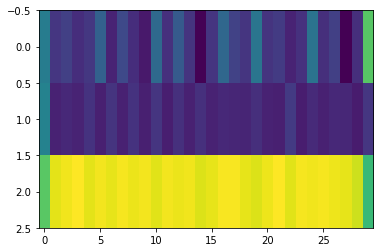

Epoch 1, FOOLING Test Accuracy: 0.00


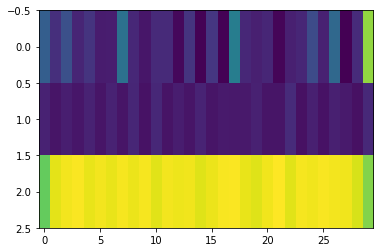

Epoch 2, FOOLING Test Accuracy: 0.00


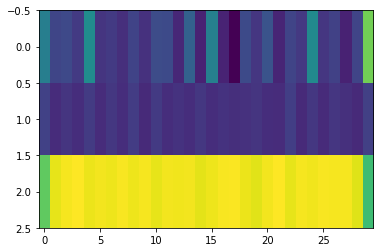

Epoch 3, FOOLING Test Accuracy: 0.00


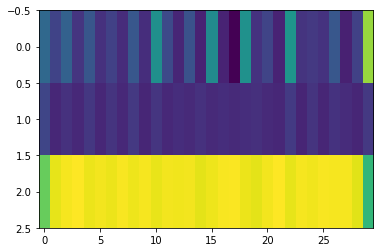

Epoch 4, FOOLING Test Accuracy: 0.00


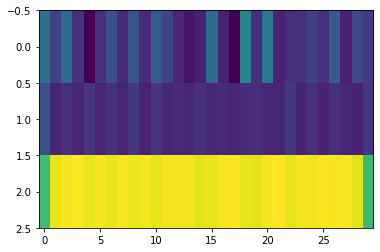

Epoch 5, FOOLING Test Accuracy: 0.00


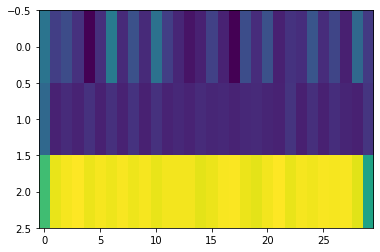

Epoch 6, FOOLING Test Accuracy: 0.00


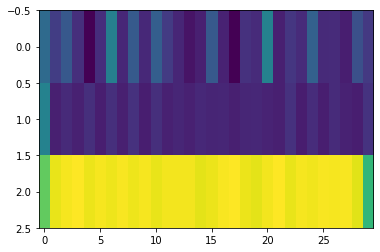

Epoch 7, FOOLING Test Accuracy: 0.00


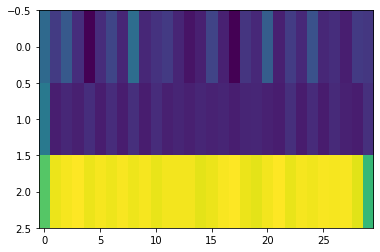

Epoch 8, FOOLING Test Accuracy: 0.00


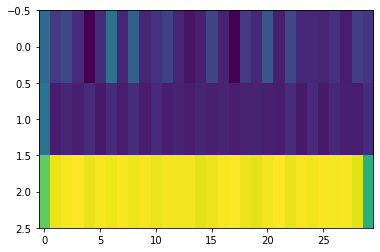

Epoch 9, FOOLING Test Accuracy: 0.00


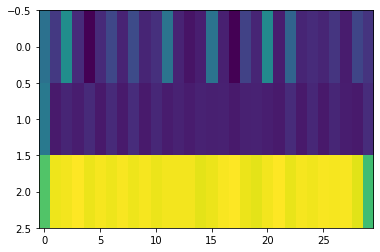

Accuracy defended vs. undefended: 0.5222094655036926 vs. 0.0


In [18]:
# Run the patch_attack function
patch_def, metrics_def = patch_attack(model_defended, train_loader, test_loader, target_class=4, patch_size=(30,3), num_epochs=10)
patch, metrics = patch_attack(model_undefended, train_loader, test_loader, target_class=4, patch_size=(30,3), num_epochs=10)

print(f'Accuracy defended vs. undefended: {metrics_def[0]} vs. {metrics[0]}')

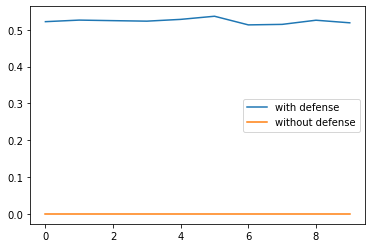

In [23]:
plt.plot(metrics_def, label="with defense")
plt.plot(metrics, label="without defense")
plt.legend()

Epoch 0, FOOLING Test Accuracy: 1.00


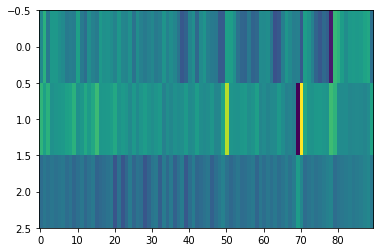

In [14]:
# Run the patch_attack function
patch_def, metrics_def = patch_attack(model_defended, train_loader, test_loader, target_class=0, patch_size=(90,3), num_epochs=1)
#patch, metrics = patch_attack(model_undefended, train_loader, test_loader, target_class=0, patch_size=(90,3), num_epochs=1)

#print(f'Accuracy defended vs. undefended: {metrics_def[0]} vs. {metrics[0]}')

Epoch 0, FOOLING Test Accuracy: 0.36


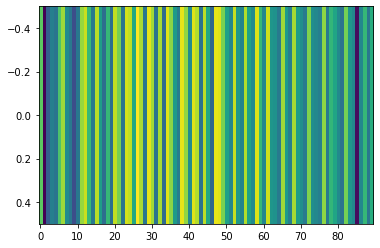

Epoch 1, FOOLING Test Accuracy: 0.37


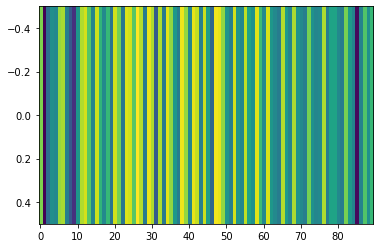

In [15]:
# Run the patch_attack function
patch, metrics = patch_attack(model_defended, train_loader, test_loader, target_class=0, patch_size=(90,1), num_epochs=2)

In [16]:
#TODO: plot the patch NOT as a 2D image, but as a signal over time (with variable # of channels)
# in an sample as well

In [ ]:
#TODO: try to attack a single dimension constantly (not randomly)
# --> would be nice if we just replace only x-dimension